## Building The Environment
<sub>Uirá Caiado. Aug 19, 2016<sub>

### My Goal, For Now

Here I will build the environment where my agent will be trained. As it is a pretty complicated task, I created this notebook just to explore some options. Test an automated strategy is something pretty difficult, to tell the truth. There are some issues that I could talk about: historical prices are just one path from a stochastic process, the presence of the strategy on the market could change it etc.

However, would be interesting if the solution explored in my capstone could capture some aspect of the real structure of the markets. So, I will build an environment that will use historical data, but I will build it in a "agent-based model" fashion. Probably I will not do that to this project, but this structure can be useful for some future projects that I intend to do after completing this one.

I will use TAQ data from Bloomberg; It consists of 'level I' data from the PETR4 Brazilian Stock. I will explain about all these terms and data in my "official" project; here I just intend to share my experiments in a less formal way. Level I data is the information of the first queue of order book (bid and ask), and trades that have been made (TAQ is an acronym for Trade and Quote). It alone is not enough to create an order book, but I will try to do that. If I complete this task, I could exclude the historical data and include some random agents to build a Monte Carlo of the order book, for example. I will try to build it upon the codes for the SmartCab project. Instead of the gridlike world, my world will be discrete, but an order book.

### Exploring The Data

So, let's start looking at the data that I have available. It is data from the last 19 days from PETR4 stock from Brazilian BMFBovespa. I choose this share because it is on of the most active stocks in our market, but still the data produced is manageable (60 to 90 thousands of rows by day).

In [42]:
import zipfile
def foo():
    s_fname = "data/petr4_0725_0818.zip"
    archive = zipfile.ZipFile(s_fname, 'r')
    f_total = 0.
    for i, x in enumerate(archive.infolist()):
        f_total += x.file_size/ 1024.**2
        for num_rows, row in enumerate(archive.open(x)):
            pass
        print "{}:\t{:,.0f} rows\t{:0.2f} MB".format(x.filename, num_rows + 1, x.file_size/ 1024.**2)
    print '=' * 42
    print "TOTAL\t\t{} files\t{:0.2f} MB".format(i+1,f_total)

%time foo()

20160725.csv:	117,170 rows	4.66 MB
20160726.csv:	105,898 rows	4.20 MB
20160727.csv:	131,058 rows	5.22 MB
20160728.csv:	117,286 rows	4.65 MB
20160729.csv:	145,368 rows	5.79 MB
20160801.csv:	114,815 rows	4.57 MB
20160802.csv:	113,642 rows	4.51 MB
20160803.csv:	142,283 rows	5.69 MB
20160804.csv:	144,832 rows	5.78 MB
20160805.csv:	117,901 rows	4.70 MB
20160808.csv:	93,502 rows	3.70 MB
20160809.csv:	86,078 rows	3.41 MB
20160810.csv:	112,320 rows	4.46 MB
20160811.csv:	153,925 rows	6.16 MB
20160812.csv:	154,212 rows	6.17 MB
20160815.csv:	114,955 rows	4.57 MB
20160816.csv:	111,913 rows	4.45 MB
20160817.csv:	122,047 rows	4.86 MB
20160818.csv:	90,024 rows	3.56 MB
TOTAL		19 files	91.09 MB
CPU times: user 6.93 s, sys: 19.2 ms, total: 6.94 s
Wall time: 6.95 s


Ok, all files together have 91 MB. It is not too much actually. Maybe I could try to get more data. Well, let's read one of them.

In [63]:
import pandas as pd
df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
df.head()

,Date,Type,Price,Size
0,2016-08-18 10:09:09,TRADE,12.80,1000
1,2016-08-18 10:09:09,BID,12.80,15900
2,2016-08-18 10:09:09,ASK,12.81,2900
3,2016-08-18 10:09:09,ASK,12.81,7900
4,2016-08-18 10:09:09,BID,12.80,20900


In [64]:
print "{:%m/%d/%Y}".format(df.Date[0])
print df.groupby('Type').count()['Date']

08/18/2016
Type
ASK      32843
BID      32116
TRADE    25064
Name: Date, dtype: int64


As it is a "Trade And quotes" file, I was already expecting that there was the same number os Bid and Ask rows in the file. Well... it wasn't a problem to read this file. Well, I will read this file row by row now and include the prices in a binomial tree. Let's see how long it takes.

In [65]:
from bintrees import FastRBTree

In [77]:
def foo():
    for idx, row in df.iterrows():
        pass

print "time to iterate the rows:"
%time foo()

time to iterate the rows:
CPU times: user 9.15 s, sys: 114 ms, total: 9.27 s
Wall time: 9.22 s


In [78]:
def foo():
    bid_tree = FastRBTree()
    ask_tree = FastRBTree()
    for idx, row in df.iterrows():
        if row.Type == 'BID':
            bid_tree.insert(row['Price'], row['Size'])
        elif row.Type == 'ASK':
            ask_tree.insert(row['Price'], row['Size'])

print "time to insert everything in binary trees:"
%time foo()

time to insert everything in binary trees:
CPU times: user 15.6 s, sys: 317 ms, total: 15.9 s
Wall time: 15.8 s


It is not excelent, but it is ok for now. I will see how bad it will be when I include all the logic needed. Now, let's visualize the prices on that day

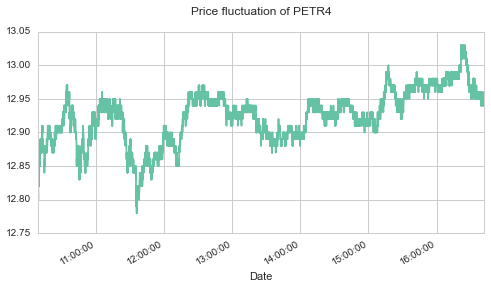

In [85]:
df_aux = df[df.Type == 'TRADE'].Price
df_aux.index = df[df.Type == 'TRADE'].Date
ax = df_aux.plot()
ax.set_title("Price fluctuation of PETR4\n");

Know what, let's visualize the prices of all days

In [ ]:
df_all = None

for i, x in enumerate(archive.infolist()):
    df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
    ts_date = df.Date[0].date()
    df.Date = ["{:%H:%M:%S}".format(x) for x in df.Date]
    df = df[df.Type == "TRADE"]
    if i == 0:
        df_all = pd.DataFrame(df.Price)
        df_all.columns = [ts_date] 
        df_all.index = df.Date
    else:
        df_aux = pd.DataFrame(df.Price)
        df_aux.columns = [ts_date]
        df_aux.index = df.Date
        df_all = df_all.join(df_aux)

In [ ]:
df_all.head()

*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))